# ML2_2020_OzonMasters. V1
### Матросов Сергей

# Распрастранение радиоактивной пыли после аварии на Чернобыльской АЭС

Данные: https://www.kaggle.com/lsind18/chernobyl-data-air-concentration

## Предварительная обработка данных

Подключаем необходимые библиотеки:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium

Загружаем данные:

In [2]:
dtypes = {
    'Duration(h.min)': str,
}

data = pd.read_csv('./data/CHERNAIR.csv', dtype=dtypes)

Для удобства переименуем некоторые столбцы:

In [3]:
data.rename(columns={
    'PAYS': 'Country',
    'X': 'Lon',
    'Y': 'Lat',
    'Duration(h.min)': 'Duration',
    'I 131 (Bq/m3)': 'I-131',
    'Cs 134 (Bq/m3)': 'Cs-134',
    'Cs 137 (Bq/m3)': 'Cs-137',
}, inplace=True)

Для удобства сопоставим сокращенные названия стран полным:

In [4]:
data['Country'].unique()

array(['SE', 'DE', 'F', 'IR', 'IT', 'NL', 'GR', 'UK', 'BE', 'ES', 'CH',
       'AU', 'FI', 'NO', 'CZ', 'HU'], dtype=object)

In [5]:
country_name_dict = {
    'SE': 'Sweden',
    'DE': 'Germany',
    'F': 'France',
    'IR': 'Ireland',
    'IT': 'Italy',
    'NL': 'Netherlands',
    'GR': 'Greece',
    'UK': 'United Kingdom',
    'BE': 'Belgium',
    'ES': 'Spain',
    'CH': 'Switzerland',
    'AU': 'Australia',
    'FI': 'Finland',
    'NO': 'Norway',
    'CZ': 'Czech Republic',
    'HU': 'Hungary',
}

Колонку `Code` можно удалить, т.к. эти коды не соответствуют стандарту [**ISO-3166**](https://en.wikipedia.org/wiki/ISO_3166) и не несут дополнительной информации:

In [6]:
data['Code'].unique()

array([ 1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 13, 14, 20, 21, 22, 23, 24],
      dtype=int64)

In [7]:
data.drop(columns=['Code'], inplace=True)

Обьединим даты и время завершения измерений в одну колонку:

In [8]:
data['Date'] = pd.to_datetime(
    '19' + data['Date'] + '-' + data['End of sampling'].replace({'24:00:00': '23:59:59'})
)
data.drop(columns=['End of sampling'], inplace=True)

Приведем колонку `Duration` к типу Timedelta:

In [9]:
def to_timedelta_str(dur_str):
    dur_split = dur_str.split('.')
    hours = int(dur_split[0])
    minutes = 0 if len(dur_split) == 1 else int(dur_split[1])
    return f'{hours:02d}:{minutes:02d}:00'

data['Duration'] = data['Duration'] \
    .apply(to_timedelta_str) \
    .apply(pd.to_timedelta)

Приведем концентрации радионуклидов к типу `float`:

In [10]:
data['I-131'] = pd.to_numeric(data['I-131'], errors='coerce')
data['Cs-134'] = pd.to_numeric(data['Cs-134'], errors='coerce')
data['Cs-137'] = pd.to_numeric(data['Cs-137'], errors='coerce')

In [11]:
data.head()

,Country,Ville,Lon,Lat,Date,Duration,I-131,Cs-134,Cs-137
0,SE,RISOE,12.07,55.7,1986-04-27 23:59:59,1 days 00:00:00,1.00000,0.00000,0.24000
1,SE,RISOE,12.07,55.7,1986-04-28 23:59:59,1 days 00:00:00,0.00460,0.00054,0.00098
2,SE,RISOE,12.07,55.7,1986-04-29 12:00:00,0 days 12:00:00,0.01470,0.00430,0.00740
3,SE,RISOE,12.07,55.7,1986-04-29 23:59:59,0 days 12:00:00,0.00061,0.00000,0.00009
4,SE,RISOE,12.07,55.7,1986-04-30 23:59:59,1 days 00:00:00,0.00075,0.00010,0.00028


## Предварительный обзор данных

Общая информация:

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype          
---  ------    --------------  -----          
 0   Country   2051 non-null   object         
 1   Ville     2051 non-null   object         
 2   Lon       2051 non-null   float64        
 3   Lat       2051 non-null   float64        
 4   Date      2051 non-null   datetime64[ns] 
 5   Duration  2051 non-null   timedelta64[ns]
 6   I-131     2009 non-null   float64        
 7   Cs-134    1801 non-null   float64        
 8   Cs-137    1506 non-null   float64        
dtypes: datetime64[ns](1), float64(5), object(2), timedelta64[ns](1)
memory usage: 144.3+ KB


Проверим данные на наличие пропусков:

In [13]:
data.isna().sum()

Country       0
Ville         0
Lon           0
Lat           0
Date          0
Duration      0
I-131        42
Cs-134      250
Cs-137      545
dtype: int64

Пропущены только данные с измерениями. <br>
Можно предположить, что в соответствующем центре мониторинга не было возможности определить концентрацию соответствующих изотопов. <br>
Эту гипотезу мы проверим ниже

Количество измерений в разных странах:

## Распределение наблюдений по странам

In [14]:
country_records = data['Country'].value_counts()
country_records.rename(country_name_dict)

Italy             303
France            260
Germany           246
Australia         223
Sweden            211
Czech Republic    134
Netherlands       121
United Kingdom    119
Finland           107
Norway             73
Belgium            72
Greece             60
Spain              44
Switzerland        42
Ireland            23
Hungary            13
Name: Country, dtype: int64

Построи соответствующую гистограмму:

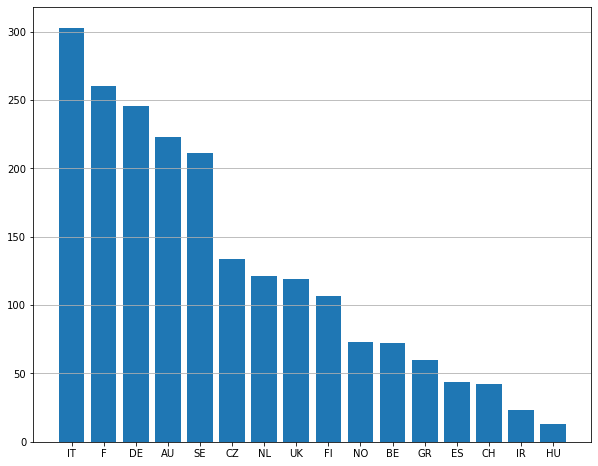

In [15]:
fig, ax = plt.subplots(figsize=(10,8))

countries = country_records.index
records = country_records.values

ax.bar(countries, records)
ax.grid(axis='y')

Посмотрим на число станций мониторинга в каждой из стран:

In [16]:
data.groupby('Country')['Ville'].describe().reindex(countries)

,count,unique,top,freq
IT,303,8,ISPRA,101
F,260,20,ST.Laurent des eaux,20
DE,246,17,GOETTINGEN,28
AU,223,7,VIENNA.,56
SE,211,6,STOCKHOLM,58
CZ,134,9,PRAHA,39
NL,121,6,BILTHOVEN,36
UK,119,4,HARWELL,52
FI,107,2,KONALA(Helsinki)NW,79
NO,73,4,OSLO,45


Выведем списки станций мониторинга:

In [17]:
villes = data.groupby('Country')['Ville'] \
    .unique() \
    .reindex(countries) \
    .rename(country_name_dict)

for country, villes in villes.items():
    print(f'{country}:\n{villes}')

Italy:
['BOLOGNA' 'BRASIMONE' 'CAPANNA' 'CASACCIA' 'ISPRA' 'SALUGGIA(eurex)'
 'SALUGGIA(IFEC)' 'TRISAIA']
France:
['CADARACHE' 'CHINON' 'CHOOZ' 'CRUAS' 'DAMPIERRE EN BURLY' 'FESSENHEIM'
 'FLAMANVILLE' 'GRAVELINES' 'GRENOBLE' 'LE BUGEY' 'LE VESINET' 'MARCOULE'
 'MONACO' 'ORSAY' 'PARIS' 'SACLAY' 'SAINT ALBAN' 'ST.Laurent des eaux'
 'TRICASTIN' 'VERDUN']
Germany:
['AACHEN(DWD)' 'AACHEN(RWTH)' 'ANSBACH' 'BERLIN-WEST' 'BROTJACKLRIEGEL'
 'FREIBURG(BZS)' 'FREIBURG(DWD)' 'GOETTINGEN' 'HANNOVER' 'KARLSRUHE'
 'MEINERZHAGEN' 'NEUHERBERG' 'NORDERNEY' 'OFFENBACH' 'ROTTENBURG'
 'STARNBERG' 'WALDHOF']
Australia:
['BREGENZ' 'GRAZ' 'INNSBRUCK' 'KLAGENFURT' 'LINZ' 'SALZBURG' 'VIENNA.']
Sweden:
['RISOE' 'GOETEBORG' 'LJUNGBYHED' 'OESTERSUND' 'STOCKHOLM' 'UMEAA']
Czech Republic:
['BANSKA' 'BRATISLAVA' 'CESKE' 'HRADEC' 'JASLOVSKE' 'KOSICE' 'MORAVSKY'
 'PRAHA' 'USTI']
Netherlands:
['BILTHOVEN' 'DELFT' 'EELDE' 'GRONINGEN' 'PETTEN' 'VLISSINGEN']
United Kingdom:
['BERKELEY' 'CHAPELCROSS' 'GLASGOW' 'HARWELL']
Fi

Посмотрим на число наблюдений различных станций:

In [18]:
data.groupby('Country')['Ville'].value_counts().reindex(countries, level=0)

Country  Ville           
IT       ISPRA               101
         CAPANNA              59
         CASACCIA             38
         TRISAIA              31
         BRASIMONE            20
                            ... 
CH       SPIEZ                20
         FRIBOURG             14
         LOCARNO Monti         8
IR       GLASNEVIN.Dublin     23
HU       BUDAPEST             13
Name: Ville, Length: 95, dtype: int64

### Станции мониторинга на карте:

In [19]:
stations_map = folium.Map(
    location=[49.873087, 12.812349],
    width=1200,
    height=600,
    zoom_start=3.5,
)

folium.Marker([51.389548, 30.096219],
              popup='Chernobyl Nuclear Power Plant',
              icon=folium.Icon(color='red', icon='info-sign')
             ).add_to(stations_map)

In [20]:
station_coords = data.groupby(['Country', 'Ville'])[['Lat', 'Lon']].mean()

Удалим некорректную запись:

In [21]:
station_coords.drop(index=[
    ('NO','VAERNES'),
    ('ES', 'VALENCIA'),
    ('CZ', 'KOSICE'),
], inplace=True)

Для Чехии перепутаны координаты:

In [22]:
station_coords.loc['CZ', :]
cz_lon_tmp = station_coords.loc['CZ', :]['Lat'].copy()
station_coords.loc['CZ', :]['Lat'] = station_coords.loc['CZ', :]['Lon']
station_coords.loc['CZ', :]['Lon'] = cz_lon_tmp

In [23]:
station_coords.loc[('CZ','BANSKA')]

Lat    48.73
Lon    19.17
Name: (CZ, BANSKA), dtype: float64

In [24]:
for index, values in station_coords.iterrows():
    lat = values['Lat']
    lon = values['Lon']
    
    folium.Circle((lat, lon),
                   radius=5,
                   color='blue',
                   popup=f'{index[0]}: {index[1]}'
                 ).add_to(stations_map)

In [25]:
stations_map

## Период наблюдений

In [26]:
data['Date'].dt.date.describe()

count           2051
unique            37
top       1986-05-02
freq             190
Name: Date, dtype: object

In [27]:
data['Date'].dt.date.aggregate(['min', 'max'])

min    1986-04-27
max    1986-08-04
Name: Date, dtype: object

Найдем частоту измерений каждый день в период наблюдений:

In [28]:
data['Date'].dt.date.value_counts().sort_index()

1986-04-27      1
1986-04-28     24
1986-04-29     45
1986-04-30     97
1986-05-01    115
1986-05-02    190
1986-05-03    173
1986-05-04    150
1986-05-05    142
1986-05-06    135
1986-05-07    133
1986-05-08    100
1986-05-09     98
1986-05-10     83
1986-05-11     76
1986-05-12     71
1986-05-13     58
1986-05-14     57
1986-05-15     48
1986-05-16     38
1986-05-17     24
1986-05-18     24
1986-05-19     30
1986-05-20     19
1986-05-21     19
1986-05-22     13
1986-05-23     18
1986-05-24      5
1986-05-25      9
1986-05-26     19
1986-05-27      4
1986-05-28      9
1986-05-29      6
1986-05-30     12
1986-05-31      4
1986-06-05      1
1986-08-04      1
Name: Date, dtype: int64

Предсказуемо, число наблюдений начинает стремительно расти через пару дней после аварии и в течение месяца сходит на нет.<br>
Пару наблюдений за июнь и август отбросим

Отобразим эти данные как гистограмму:

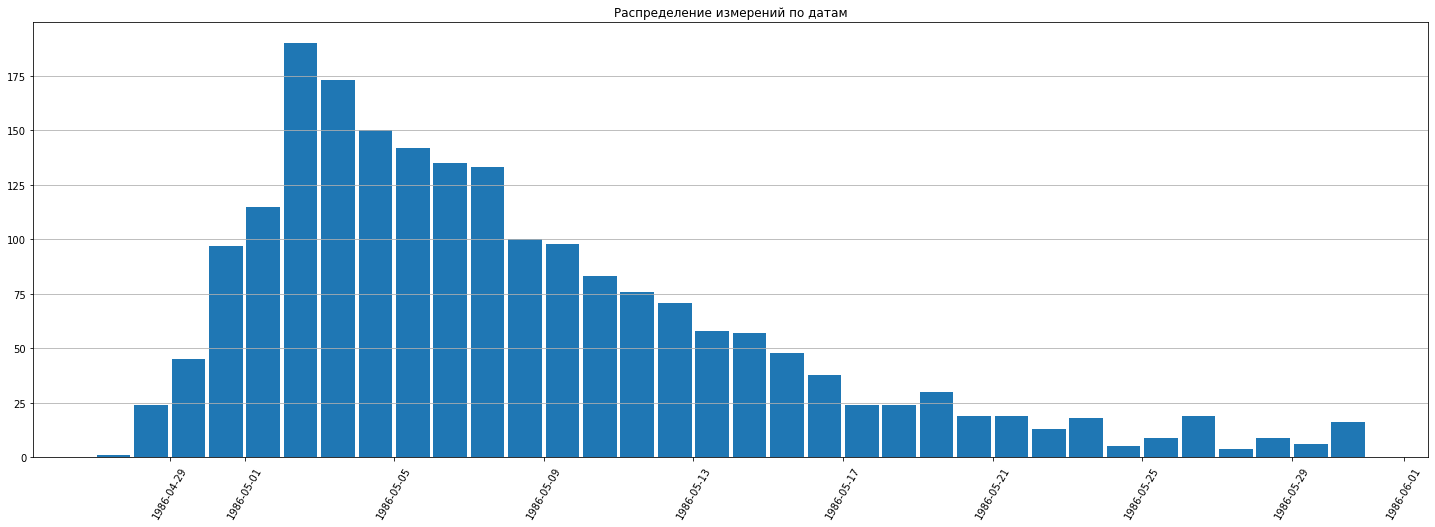

In [29]:
fig, ax = plt.subplots(figsize=(25,8))

dates = data['Date'].dt.date.sort_values().iloc[:-2]
num_days = (dates.max() - dates.min()).days

dates.hist(
    bins=num_days,
    ax=ax,
    rwidth=0.9,
)
ax.grid(axis='x')
ax.set_title('Распределение измерений по датам')
ax.tick_params(axis='x', rotation=60)

## Распределение длительности наблюдений

In [30]:
data['Duration'].describe()

count                      2051
mean     0 days 20:48:57.952218
std      1 days 17:20:51.661710
min             0 days 00:02:00
25%             0 days 06:00:00
50%             1 days 00:00:00
75%             1 days 00:00:00
max            29 days 04:00:00
Name: Duration, dtype: object

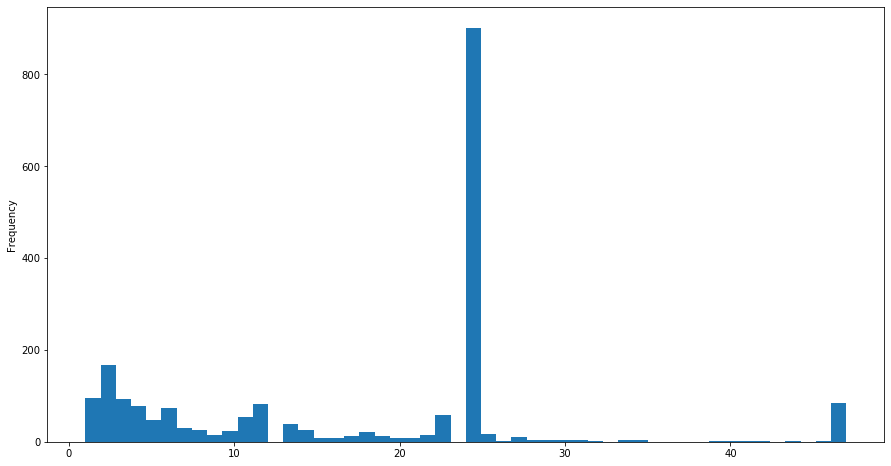

In [31]:
fig, ax = plt.subplots(figsize=(15,8))

q5, q95 = data['Duration'].quantile([.01, .96])
data['Duration'].clip(lower=q5, upper=q95).astype('timedelta64[h]').plot.hist(bins=50, ax=ax)

## Концентрации радионуклидов

In [32]:
data[['I-131', 'Cs-134', 'Cs-137']].describe()

,I-131,Cs-134,Cs-137
count,2009.000000,1801.000000,1506.000000
mean,1.748547,0.246130,0.480119
std,5.037676,0.752174,1.036107
min,0.000000,0.000000,0.000000
25%,0.003400,0.000000,0.001600
50%,0.060000,0.002035,0.020000
75%,1.140000,0.170000,0.479325
max,70.000000,14.000000,11.900000


Динамика средней концентрации радионуклидов со временем:

In [33]:
concentrations_df = data[['I-131', 'Cs-134', 'Cs-137']].copy()
concentrations_df['Date'] = data['Date'].dt.date

In [34]:
concentration_stats = concentrations_df.groupby('Date') \
    .agg(['mean', 'std']) \
    .sort_index() \
    .fillna(0.) \
    .iloc[:-2]

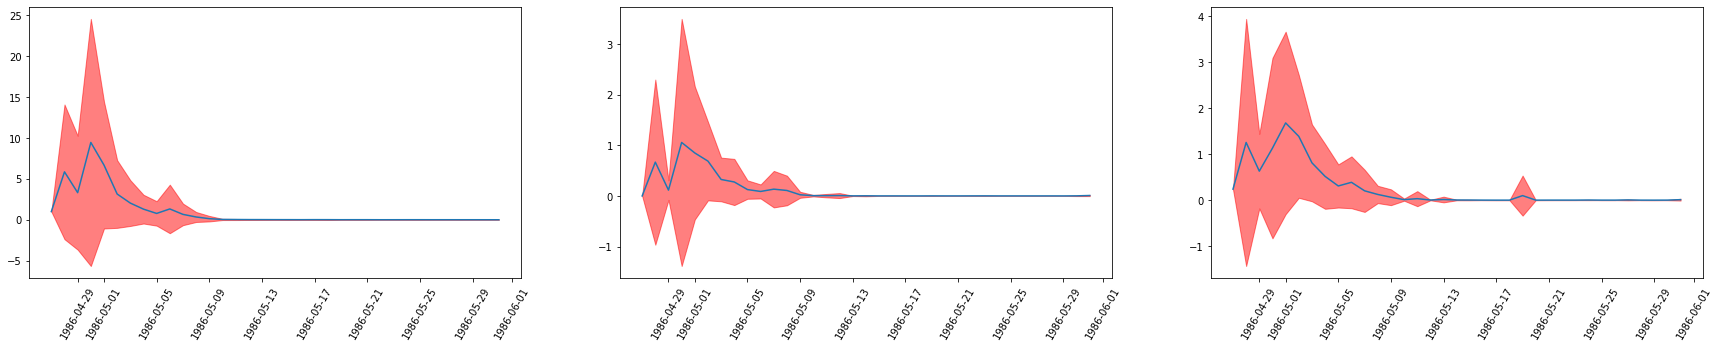

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30,5))

dates = concentration_stats.index

mean = concentration_stats[('I-131', 'mean')]
std = concentration_stats[('I-131', 'std')]
ax[0].plot(dates, mean)
ax[0].fill_between(dates, mean-std, mean+std, color='red', alpha=0.5)
ax[0].tick_params(axis='x', rotation=60)

mean = concentration_stats[('Cs-134', 'mean')]
std = concentration_stats[('Cs-134', 'std')]
ax[1].plot(dates, mean)
ax[1].fill_between(dates, mean-std, mean+std, color='red', alpha=0.5)
ax[1].tick_params(axis='x', rotation=60)

mean = concentration_stats[('Cs-137', 'mean')]
std = concentration_stats[('Cs-137', 'std')]
ax[2].plot(dates, mean)
ax[2].fill_between(dates, mean-std, mean+std, color='red', alpha=0.5)
ax[2].tick_params(axis='x', rotation=60)

Отклонения от средних достаточно значительны, из чего следует неравномерность распределения загрязнения

## Кумулятивное загрязнение

In [36]:
# TODO: доделать